In [ ]:
import torch
from torch import optim, distributions, nn
import numpy as np
from torch import distributions
from torch.distributions import constraints, transform_to
import torch.nn as nn
from gpzoo.utilities import add_jitter, svgp_forward, reshape_param
import gpzoo.pri_experiment_utilities as putil
from gpzoo.likelihoods import NSF2
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, anndata_to_train_val, add_jitter, scanpy_sizefactors 
from tqdm import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [90]:
def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

In [91]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
#print("Current GPU: ", torch.cuda.current_device())
#print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2


In [92]:
torch.manual_seed(256)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [93]:
def twod_indexes(indexes):
    torch.vmap(torch.cartesian_prod)(index)(index)

In [94]:
import torch
import torch.nn as nn
import numpy as np
from torch.distributions import constraints, transform_to

def add_jitter(K, jitter):
    return K + jitter * torch.eye(K.shape[-1], device=K.device)

class VNNGP(nn.Module):
    def __init__(self, kernel, dim=1, M=50, K=3, jitter=1e-4):
        super().__init__()
        self.kernel = kernel
        self.jitter = jitter

        self.K = K
        self.Z = nn.Parameter(torch.randn((M, dim)))  # choose inducing points
        self.Lu = nn.Parameter(torch.randn((M, M)))
        self.mu = nn.Parameter(torch.zeros((M,)))
        self.constraint = constraints.lower_cholesky
        self.indexes = []

        print("K: ", self.K)
        print("Z Shape: ", self.Z.shape)
        print("Lu Shape: ", self.Lu.shape)
        print("Mu: Shape ", self.mu.shape)

    def forward(self, X, verbose=False, **kwargs):
        lkzz_build = kwargs['kwargs']['lkzz_build']
        Kxx = self.kernel(X, X, diag=True)
        Kxx_shape = Kxx.shape
        Kxx = Kxx.contiguous().view(-1, 1)  # (... x N) x 1

        if verbose:
            print("Kxx shape before contiguous().view(-1, 1): ", Kxx_shape)
            print('calculating Kxx')
            print('Kxx.shape', Kxx.shape)

        
        Kxz, distances = self.kernel(X, self.Z, return_distance=True)

        Kxz_shape = Kxz.shape
        Kxz = Kxz.contiguous().view(-1, Kxz_shape[-1])  # (... x N) x M

        if verbose:
            print("Kxz shape before contiguous().view(-1, 1): ", Kxz_shape)
            print("distances shape:: ", distances.shape)
            print('calculating Kxz')
            print('Kxz.shape', Kxz.shape)

        Kzz = self.kernel(self.Z, self.Z)

        Kzz_shape = Kzz.shape
        Kzz = Kzz.contiguous().view(-1, Kzz_shape[-2], Kzz_shape[-1])  # ... x M x M

        if verbose:
            print("Kzz shape before contiguous().view(..): ", Kzz_shape)
            print('calculating kzz')
            print('Kzz.shape', Kzz.shape)

        Lu = transform_to(self.constraint)(self.Lu)
        Lu_shape = Lu.shape
        Lu = Lu.contiguous().view(-1, Lu_shape[-2], Lu_shape[-1])  # ... x M x M
        indexes = torch.argsort(distances, dim=1)[:, :self.K]
        self.indexes = indexes

        if verbose:
            print("indexes.shape: ", indexes.shape)

        little_Kzz = None  
       
        if lkzz_build == 0:  # cholesky decomposition
            L = torch.linalg.cholesky(add_jitter(Kzz, self.jitter))  # ... x M x M
            L_shape = L.shape
            L = L.contiguous().view(-1, L_shape[-2], L_shape[-1])  # ... x M x M

            if verbose:
                print("indexes.shape: ", indexes.shape)
                print(indexes)
                print('calculating L')
                print('L.shape', L.shape)

            indexes = torch.argsort(distances, dim=1)[:, :self.K]
            little_L = L[:, indexes]  # ... x N x K x M

            if verbose:
                print('Little_L.shape:', little_L.shape)

            little_Kzz = little_L @ torch.transpose(little_L, -2, -1)  # ... x N x K x K
            little_Kzz_shape = little_Kzz.shape
            little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])  # ( ... x N) x K x K

        elif lkzz_build == 1:  # indexing with np.arange into Kzz
            jitter = 1e-6
            Kzz_jittered = Kzz + jitter * torch.eye(Kzz.shape[-1], device=Kzz.device)

            batch_size = Kzz_jittered.shape[:-2]
            N = indexes.shape[-2]
            K = indexes.shape[-1]

            # gather appropriate submatrices
            batch_indices = torch.arange(batch_size[0], device=Kzz.device).view(-1, 1, 1)
            little_L = Kzz_jittered[batch_indices, indexes]

            little_Kzz = little_L @ torch.transpose(little_L, -2, -1)

            little_Kzz_shape = little_Kzz.shape
            little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])

            if verbose:
                print("little_Kzz_shape before contiguous(): ", little_Kzz_shape)
                print("little_Kzz: ", little_Kzz.shape)

        elif lkzz_build == 2:
            # Directly construct little_Kzz
            def construct_little_Kzz(Z, indexes):
                def kernel_func(i):
                    return self.kernel(Z[i], Z[i])
                return torch.vmap(kernel_func)(indexes)

            little_Kzz = construct_little_Kzz(self.Z, indexes)

            if verbose:
                print('Little_Kzz.shape:', little_Kzz.shape)

            little_Kzz_shape = little_Kzz.shape
            little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])  # ( ... x N) x K x K

        elif lkzz_build == 3:
            if verbose:
                print("Running new lkzz code")
                print("Directly constructing little_Kzz")

            N = X.shape[0]
            K = self.K
            L = Kzz.shape[0]
            lkzz = np.zeros((L, N, K, K))  # L x N x K x K

            # Create an array of indices from 0 to N-1
            indices = np.arange(N)
            
            # Extract the required submatrices using advanced indexing
            little_Kzz = torch.vmap(lambda x: Kzz[:, x][:, :, x])(indexes)
            little_Kzz = little_Kzz.transpose(0,1)
            little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()
            little_Kzz_shape = little_Kzz.shape
            little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])  # ( ... x N) x K x K

        if little_Kzz is None:
            raise ValueError("little_Kzz is not set. Please check the lkzz_build logic.")

        kzz_inv = torch.inverse(add_jitter(little_Kzz, self.jitter))  # (... x N) x KxK

        expanded = indexes.repeat(Kxx_shape[0], 1)

        little_Kxz = torch.gather(Kxz, 1, expanded)[:, None, :]  # (... x N)x1xK

        W = little_Kxz @ kzz_inv  # (... x N) x 1 x K # issue is here

        if verbose:
            print('W_shape:', W.shape)

        mu_shape = self.mu.shape

        mu = self.mu.contiguous().view(-1, mu_shape[-1])  # ... x M

        little_mu = mu[:, indexes]  # ... x  N x K
        little_mu = little_mu.view(-1, little_mu.shape[-1])  # (... x  N) x K

        little_Lu = Lu[:, indexes]  # ... x N x K x M
        little_S = little_Lu @ torch.transpose(little_Lu, -2, -1)  # ... x N x K x K
        little_S = little_S.contiguous().view(-1, little_S.shape[-2], little_S.shape[-1])  # (... x N) x K x K

        if verbose:
            print(Kxx.shape, little_Kzz.shape, W.shape, little_mu.shape, little_S.shape)
        mean, cov = svgp_forward(Kxx, little_Kzz, W, little_mu, little_S)

        if verbose:
            print('mean.shape:', mean.shape)
            print('cov.shape:', cov.shape)

        mean = torch.squeeze(mean)
        cov = torch.squeeze(cov)

        mean = mean.contiguous().view(*Kxx_shape)
        cov = cov.contiguous().view(*Kxx_shape)

        qF = distributions.Normal(mean, torch.clamp(cov, min=5e-2) ** 0.5)
        qU = distributions.MultivariateNormal(self.mu, scale_tril=Lu)
        # pU = distributions.MultivariateNormal(torch.zeros_like(self.mu), scale_tril=L)
        # pU = distributions.MultivariateNormal(torch.zeros_like(self.mu), covariance_matrix=Kzz)
        pU = cov, mean
        return qF, qU, pU


In [95]:
X, Y = putil.load_visium()

In [96]:
# load NMF
nmf_path = '/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L=10.pt'
factors, loadings = putil.preloaded_nmf_factors(nmf_path)
moran_idx, moranI = putil.dims_autocorr(factors, X)
factors=factors[:, moran_idx]
loadings=loadings[:, moran_idx]



In [97]:
kwargs = {'L': 10, 
         'M': 1000, 
         'K': 5,
         'sigma': 0.1, 
         'lengthscale': 0.07, 
         'jtr': 1e-2,
         'batch_size': 128,
         'lr': 1e-3,
         'rs': 256,
         'lkzz_build': 3}

In [98]:
V = scanpy_sizefactors(Y.T)

kmeans = putil.inducing_points_cluster_centers(X, kwargs['M'], random_state=kwargs['rs'])
Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])

X = torch.tensor(X).type(torch.float)
print(X.shape)
Y = torch.tensor(Y).type(torch.float)
Kzx = kernel.forward(Z, X)
Kxz = torch.transpose(Kzx, -2, -1)
Kzz = kernel.forward(Z, Z)

all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-4))
    
solved1 = torch.cholesky_solve(Kzx @ all_factors, L1)
mu = (Kzz @ solved1).to(device)
gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M'])
gp.Lu = nn.Parameter(Lu.clone().detach())
    
gp.Z = nn.Parameter(Z, requires_grad=False)

model = NSF2(gp, Y, L=kwargs['L'])

if loadings is not None:
    model.W = nn.Parameter(torch.tensor(putil.init_softplus(loadings)[:, :kwargs['L']]).type(torch.float))
model.V = nn.Parameter(torch.squeeze(torch.tensor(putil.init_softplus(V)).type(torch.float)))

K:  5
Z Shape:  torch.Size([1000, 1])
Lu Shape:  torch.Size([1000, 1000])
Mu: Shape  torch.Size([1000])
torch.Size([2688, 2])


In [99]:
gp.indexes

[]

Text(0.5, 1.0, 'Inducing Points')

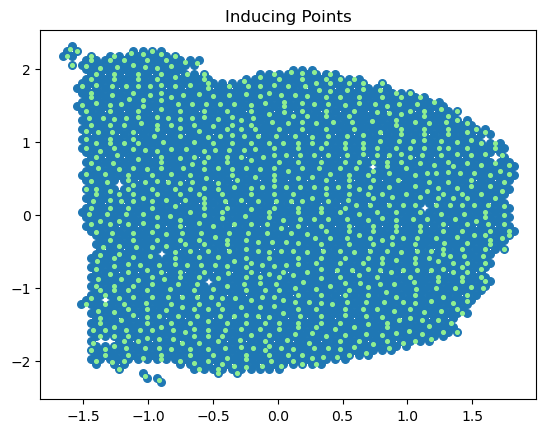

In [100]:
plt.scatter(X[:,0], X[:,1], s=30)
plt.scatter(Z.detach().numpy()[:,0], Z.detach().numpy()[:,1], c="lightgreen", s=7)
plt.title("Inducing Points")

In [101]:
print(X.shape)
print(Y.shape)

torch.Size([2688, 2])
torch.Size([11925, 2688])


In [102]:
model.to(device)

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [103]:
putil.model_grads(model)
model.prior.jitter=kwargs['jtr']
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
steps=100

In [104]:
#X = torch.tensor(X).type(torch.float)
#X = torch.tensor(Y).type(torch.float)
#X = X.to(device)

In [105]:
def train_new_KL_batched(model, optimizer, X, y, device, steps=200, E=20, verbose=False, batch_size=1000, **kwargs):
    kwargs = kwargs['kwargs']
    #print(kwargs)
    losses = []
    means = []
    scales = []
    idxs = []

    for it in tqdm(range(steps)):
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        optimizer.zero_grad()
        #X = torch.tensor(X).type(torch.float).
        pY, qF, qU, pU = model.forward_batched(X=X, idx=idx, E=E, verbose=verbose, kwargs=kwargs)
        
        logpY = y[:, idx]*torch.log(pY.rate) - (pY.rate)


        ELBO = ((logpY).mean(axis=0).sum()).to(device)
        ELBO -= torch.sum(torch.vmap(putil.vnngp_kl)(qU.mean, qU.scale_tril, model.prior.Lu, model.prior.mu))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales, idxs

In [106]:
#start_time = time.time()
X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)
losses, means, scales, idxs = train_new_KL_batched(model, optimizer, X, Y, device,
                                                steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
#end_time = time.time()
#final_time = end_time - start_time

/tmp/ipykernel_1580970/2218229987.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float).to(device)
/tmp/ipykernel_1580970/2218229987.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float).to(device)
  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1580970/2643988184.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()
100%|██████████████████████████████████

In [ ]:
  def forward(self, X, verbose=False, **kwargs):
    lkzz_build = kwargs['kwargs']['lkzz_build']
    Kxx = self.kernel(X, X, diag=True)
    Kxx_shape = Kxx.shape
    Kxx = Kxx.contiguous().view(-1, 1) # (... x N) x 1

    if verbose:
      print("Kxx shape before contiguous().view(-1, 1): ", Kxx_shape)
      print('calculating Kxx')
      print('Kxx.shape', Kxx.shape)
    

    Kxz, distances = self.kernel(X, self.Z, return_distance=True)

    Kxz_shape = Kxz.shape
    Kxz = Kxz.contiguous().view(-1, Kxz_shape[-1]) # (... x N) x M

    if verbose:
      print("Kxz shape before contiguous().view(-1, 1): ", Kxz_shape)
      print("distances shape:: ", distances.shape)
      print('calculating Kxz')
      print('Kxz.shape', Kxz.shape)

    Kzz = self.kernel(self.Z, self.Z)

    Kzz_shape = Kzz.shape
    Kzz = Kzz.contiguous().view(-1, Kzz_shape[-2], Kzz_shape[-1]) # ... x M x M

    if verbose:
      print("Kzz shape before contiguous().view(..): ", Kzz_shape)
      print('calculating kzz')
      print('Kzz.shape', Kzz.shape)

    Lu = transform_to(self.constraint)(self.Lu)
    Lu_shape = Lu.shape
    Lu = Lu.contiguous().view(-1, Lu_shape[-2], Lu_shape[-1]) # ... x M x M
    indexes = torch.argsort(distances, dim=1)[:, :self.K]

    if lkzz_build == 0: # cholesky decomposition
      L = torch.linalg.cholesky(add_jitter(Kzz, self.jitter)) # ... x M x M
      L_shape = L.shape
      L = L.contiguous().view(-1, L_shape[-2], L_shape[-1]) # ... x M x M

      if verbose:
        print("indexes.shape: ", indexes.shape)
        print('calculating L')
        print('L.shape', L.shape)


      indexes = torch.argsort(distances, dim=1)[:, :self.K]
      little_L = L[:, indexes] # ... x N x K x M

      if verbose:
        print('Little_L.shape:', little_L.shape)

      little_Kzz = little_L @ torch.transpose(little_L, -2, -1) # ... x N x K x K
      little_Kzz_shape = little_Kzz.shape
      little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1]) # ( ... x N) x K x K
    
    elif lkzz_build == 1: # indexing with np.arange into Kzz
      jitter = 1e-6
      Kzz_jittered = Kzz + jitter * torch.eye(Kzz.shape[-1], device=Kzz.device)

      batch_size = Kzz_jittered.shape[:-2]
      N = indexes.shape[-2]
      K = indexes.shape[-1]

      # gather appropriate submatrices
      batch_indices = torch.arange(batch_size[0], device=Kzz.device).view(-1, 1, 1)
      little_L = Kzz_jittered[batch_indices, indexes]

      little_Kzz = little_L @ torch.transpose(little_L, -2, -1)

      little_Kzz_shape = little_Kzz.shape
      little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])

      if verbose:
        print("little_Kzz_shape before contiguous(): ", little_Kzz_shape)
        print("little_Kzz: ", little_Kzz.shape)

    
    elif lkzz_build == 2:
      # Directly construct little_Kzz
      def construct_little_Kzz(Z, indexes):
          def kernel_func(i):
              return self.kernel(Z[i], Z[i])
          return torch.vmap(kernel_func)(indexes)
          
      little_Kzz = construct_little_Kzz(self.Z, indexes)

      if verbose:
          print('Little_Kzz.shape:', little_Kzz.shape)

      little_Kzz_shape = little_Kzz.shape
      little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])  # ( ... x N) x K x K

    elif lkzz_build == 3:
      print("lkzz == 3")
      if verbose:
          print("Running new lkzz code")
          print("Directly constructing little_Kzz")

      N = X.shape[0]
      K = self.K
      L = Kzz.shape[0]
      lkzz = torch.zeros((L, N, K, K))  # L x N x K x K
      
      indices = np.arange(N)
      
      for l in range(L):
          idx = indexes[indices]
          llkzz = Kzz[l, idx][:, idx]
          lkzz[l, :, :, :] = llkzz

      '''
          for l in range(Kzz.shape[0]):
          for n in range(N):
              idx = indexes[n]
              if verbose:
                  print("Kzz[l, idx][:, idx] shape: ", (Kzz[l, idx][:, idx]).shape)
              
              llkzz = Kzz[l, idx][:, idx]  # extracts Kzz[l, idx, idx]
              if verbose:
                  print("lkzz shape: ", lkzz.shape)
              lkzz[l, n, :, :] = llkzz
        
      '''
      little_Kzz = torch.tensor(lkzz, device=Kzz.device).float()
      little_Kzz_shape = little_Kzz.shape
      little_Kzz = little_Kzz.contiguous().view(-1, little_Kzz_shape[-2], little_Kzz_shape[-1])  # ( ... x N) x K x K

    kzz_inv = torch.inverse(add_jitter(little_Kzz, self.jitter)) # (... x N) x KxK

    expanded = indexes.repeat(Kxx_shape[0], 1)

    little_Kxz = torch.gather(Kxz, 1, expanded)[:, None, :] #(... x N)x1xK
    
    W = little_Kxz  @ kzz_inv # (... x N) x 1 x K # issue is here

    if verbose:
      print('W_shape:', W.shape)

    mu_shape = self.mu.shape

    mu = self.mu.contiguous().view(-1, mu_shape[-1]) # ... x M

    little_mu = mu[:, indexes]# ... x  N x K
    little_mu = little_mu.view(-1, little_mu.shape[-1]) # (... x  N) x K

    little_Lu = Lu[:, indexes] # ... x N x K x M
    little_S = little_Lu @ torch.transpose(little_Lu, -2, -1) # ... x N x K x K
    little_S = little_S.contiguous().view(-1, little_S.shape[-2], little_S.shape[-1]) # (... x N) x K x K

    if verbose:
      print(Kxx.shape, little_Kzz.shape, W.shape, little_mu.shape, little_S.shape)
    mean, cov = svgp_forward(Kxx, little_Kzz, W, little_mu, little_S)

    if verbose:
      print('mean.shape:', mean.shape)
      print('cov.shape:', cov.shape)

    mean = torch.squeeze(mean)
    cov = torch.squeeze(cov)

    mean = mean.contiguous().view(*Kxx_shape)
    cov = cov.contiguous().view(*Kxx_shape)

    qF = distributions.Normal(mean, torch.clamp(cov, min=5e-2) ** 0.5)
    qU = distributions.MultivariateNormal(self.mu, scale_tril=Lu)
    #pU = distributions.MultivariateNormal(torch.zeros_like(self.mu), scale_tril=L)
    #pU = distributions.MultivariateNormal(torch.zeros_like(self.mu), covariance_matrix=Kzz)
    pU = cov, mean

    return qF, qU, pU